**SVM FOR LANDCOVER CLASSIFICATION**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/AIA_Exercises/AIA_Exercise_SVM

/content/drive/MyDrive/AIA_Exercises/AIA_Exercise_SVM


# Install required packages.

In [ ]:
import pandas as pd
import numpy as np
import scipy.io as scio
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import cv2
import seaborn as sns
import matplotlib as mpl

# Open the image and the Ground Truth.

In [ ]:
PaviaU = scio.loadmat("./Hyperspectral_data_and_code/PaviaU.mat")
PaviaU_gt = scio.loadmat("./Hyperspectral_data_and_code/PaviaU_gt.mat")

a, b = 0, 8000
Image = (PaviaU['paviaU'] - a) / (b - a)  # normalization as for the Ground Truth
Image_gt = PaviaU_gt['paviaU_gt']

h, w, d = Image.shape  # check and interpret the output

# Split the training and test set.

In [ ]:
mask_w, mask_h = np.nonzero(np.transpose(Image_gt))
GT = np.concatenate((Image[mask_h, mask_w, :], Image_gt[mask_h, mask_w][:, None]), axis=-1)
ind = np.loadtxt('ind.txt', dtype=np.int32) - 1
TR = GT[ind, :]  # Training Set
TS = np.delete(GT, ind, 0)  # Test set

# Display Image.

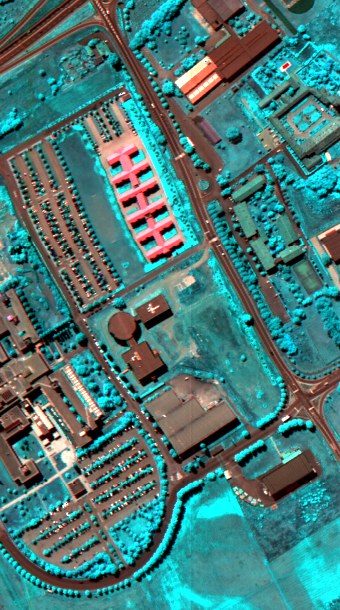

In [ ]:
from google.colab.patches import cv2_imshow

A = PaviaU['paviaU'].reshape(-1, d)

Adisp_data = A

def histstretch(data):
    cur_lim = np.quantile(data, (0.025, 0.975))
    data = np.maximum(cur_lim[0], np.minimum(cur_lim[1], data))
    data = np.floor(255*(data-cur_lim[0])/(cur_lim[1]-cur_lim[0]))
    return data

for k in range(d):
    Adisp_data[:, k] = histstretch(Adisp_data[:, k])

red = Adisp_data.reshape(h, w, d)[:, :, 19]
green = Adisp_data.reshape(h, w, d)[:, :, 79]
blue = Adisp_data.reshape(h, w, d)[:, :, 99]
image = np.concatenate((blue[:, :, None], green[:, :, None], red[:, :, None]), axis=-1)
cv2_imshow(image)

# Classification with parametric models QDA and LDA.

Bayes Classifier (Quadratic Discriminative Analysis) using two bands as input

In [ ]:
X = np.concatenate((TR[:, 9][:, None], TR[:, 19][:, None]), axis=-1)
y = TR[:, -1]
qda_model = QDA()
qda_model.fit(X, y)
qda_pred_y = qda_model.predict(np.concatenate((TS[:, 9][:, None], TS[:, 19][:, None]), axis=-1))
truth = TS[:, -1]
L = np.concatenate((qda_pred_y[:, None], truth[:, None]), axis=-1)
df = pd.DataFrame(L, columns=('prediction', 'truth'))
CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
OA = np.sum(np.diagonal(CM.values)) / truth.shape[0]

In [ ]:
CM  # Confusion Matrix

truth,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
prediction,,,,,,,,,
1.0,4008.0,543.0,718.0,55.0,1.0,180.0,529.0,362.0,11.0
2.0,996.0,16543.0,12.0,1855.0,0.0,3433.0,15.0,51.0,168.0
3.0,13.0,0.0,8.0,0.0,0.0,1.0,1.0,10.0,0.0
4.0,0.0,420.0,1.0,811.0,0.0,22.0,0.0,0.0,297.0
5.0,77.0,0.0,11.0,6.0,1278.0,82.0,1.0,5.0,1.0
6.0,373.0,265.0,72.0,8.0,3.0,630.0,36.0,184.0,0.0
7.0,121.0,1.0,148.0,0.0,0.0,14.0,175.0,114.0,0.0
8.0,752.0,7.0,1023.0,0.0,1.0,444.0,504.0,2766.0,0.0
9.0,0.0,23.0,0.0,173.0,0.0,3.0,0.0,0.0,411.0


In [ ]:
OA  # Overall Accuracy

0.653080243280361

Try to run the following block of code.

In [ ]:
X = TR[:, 0:-1]
y = TR[:, -1]
qda_model = QDA()
qda_model.fit(X, y)
qda_pred_y = qda_model.predict(TS[:, 0:-1])
truth = TS[:, -1]
L = np.concatenate((qda_pred_y[:, None], truth[:, None]), axis=-1)
df = pd.DataFrame(L, columns=('prediction', 'truth'))
CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
OA = np.sum(np.diagonal(CM.values)) / truth.shape[0]

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Gaussian Maximum Likelihood (Quadratic Discriminative Analysis with equal priors)

In [ ]:
classes = np.max(TR[:, -1])
X = np.concatenate((TR[:, 9][:, None], TR[:, 19][:, None]), axis=-1)
y = TR[:, -1]
qda_model = QDA(priors=np.full((int(classes),), 1/classes))
qda_model.fit(X, y)
qda_pred_y = qda_model.predict(np.concatenate((TS[:, 9][:, None], TS[:, 19][:, None]), axis=-1))
truth = TS[:, -1]
L = np.concatenate((qda_pred_y[:, None], truth[:, None]), axis=-1)
df = pd.DataFrame(L, columns=('prediction', 'truth'))
CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
OA = np.sum(np.diagonal(CM.values)) / truth.shape[0]

In [ ]:
CM  # Confusion Matrix

truth,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
prediction,,,,,,,,,
1.0,3536.0,863.0,320.0,76.0,1.0,186.0,85.0,95.0,10.0
2.0,309.0,10055.0,2.0,357.0,0.0,2450.0,7.0,21.0,3.0
3.0,162.0,0.0,95.0,0.0,1.0,3.0,34.0,183.0,0.0
4.0,3.0,4884.0,3.0,1638.0,0.0,438.0,0.0,5.0,153.0
5.0,92.0,0.0,13.0,8.0,1279.0,97.0,1.0,5.0,1.0
6.0,750.0,1838.0,71.0,30.0,2.0,1083.0,31.0,164.0,0.0
7.0,1056.0,16.0,906.0,0.0,0.0,131.0,902.0,779.0,0.0
8.0,432.0,4.0,583.0,0.0,0.0,415.0,201.0,2240.0,0.0
9.0,0.0,142.0,0.0,799.0,0.0,6.0,0.0,0.0,721.0


In [ ]:
OA  # Overall Accuracy

0.5284726309593879

Linear discriminant Analysis

In [ ]:
X = TR[:, 0:-1]
y = TR[:, -1]
lda_model = LDA()
lda_model.fit(X, y)
lda_pred_y = lda_model.predict(TS[:, 0:-1])
truth = TS[:, -1]
L = np.concatenate((lda_pred_y[:, None], truth[:, None]), axis=-1)
df = pd.DataFrame(L, columns=('prediction', 'truth'))
CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
OA = np.sum(np.diagonal(CM.values)) / truth.shape[0]

In [ ]:
CM  # Confusion Matrix

truth,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
prediction,,,,,,,,,
1.0,5449.0,0.0,51.0,21.0,1.0,19.0,637.0,211.0,3.0
2.0,32.0,16586.0,7.0,358.0,2.0,1542.0,0.0,18.0,0.0
3.0,72.0,8.0,1304.0,0.0,1.0,46.0,0.0,566.0,0.0
4.0,0.0,335.0,0.0,2503.0,0.0,2.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,1277.0,0.0,0.0,0.0,0.0
6.0,128.0,846.0,5.0,12.0,2.0,2823.0,4.0,78.0,0.0
7.0,345.0,0.0,4.0,0.0,0.0,4.0,611.0,39.0,0.0
8.0,313.0,27.0,622.0,3.0,0.0,373.0,9.0,2580.0,0.0
9.0,1.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,885.0


In [ ]:
OA  # Overall Accuracy

0.8342652540710221

# SVM Classification

Linear SVM model with fixed C value

In [ ]:
X = TR[:, 0:-1]
y = TR[:, -1]
SVM_lin_model = SVC(C=100, kernel="linear")
SVM_lin_model.fit(X, y)
ypred = SVM_lin_model.predict(TS[:, 0:-1])
truth = TS[:, -1]
L = np.concatenate((ypred[:, None], truth[:, None]), axis=-1)
df = pd.DataFrame(L, columns=('prediction', 'truth'))
CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
OA = np.sum(np.diagonal(CM.values)) / truth.shape[0]

In [ ]:
CM  # Confusion Matrix

truth,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
prediction,,,,,,,,,
1.0,5902.0,0.0,110.0,0.0,0.0,2.0,860.0,102.0,2.0
2.0,41.0,17191.0,14.0,463.0,1.0,1231.0,0.0,23.0,0.0
3.0,61.0,0.0,1439.0,0.0,0.0,2.0,0.0,208.0,0.0
4.0,0.0,145.0,0.0,2438.0,0.0,3.0,0.0,0.0,0.0
5.0,0.0,2.0,0.0,1.0,1277.0,9.0,0.0,0.0,0.0
6.0,22.0,457.0,1.0,6.0,0.0,3550.0,0.0,65.0,0.0
7.0,98.0,0.0,0.0,0.0,5.0,0.0,400.0,2.0,1.0
8.0,215.0,7.0,429.0,0.0,0.0,12.0,1.0,3092.0,0.0
9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,885.0


In [ ]:
OA  # Overall Accuracy

0.8871394938198941

Linear SVM model with fixed C value

In [ ]:
X = TR[:, 0:-1]
y = TR[:, -1]
SVM_lin_model = SVC(C=1000, kernel="linear")
SVM_lin_model.fit(X, y)
ypred = SVM_lin_model.predict(TS[:, 0:-1])
truth = TS[:, -1]
L = np.concatenate((ypred[:, None], truth[:, None]), axis=-1)
df = pd.DataFrame(L, columns=('prediction', 'truth'))
CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
OA = np.sum(np.diagonal(CM.values)) / truth.shape[0]

In [ ]:
CM

truth,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
prediction,,,,,,,,,
1.0,5808.0,0.0,75.0,0.0,0.0,2.0,431.0,136.0,2.0
2.0,29.0,17026.0,12.0,379.0,1.0,947.0,0.0,16.0,0.0
3.0,94.0,0.0,1604.0,0.0,0.0,4.0,0.0,504.0,0.0
4.0,0.0,120.0,0.0,2522.0,0.0,2.0,0.0,0.0,0.0
5.0,0.0,3.0,0.0,1.0,1277.0,10.0,0.0,0.0,0.0
6.0,14.0,647.0,0.0,6.0,0.0,3834.0,0.0,74.0,0.0
7.0,248.0,0.0,0.0,0.0,5.0,0.0,828.0,1.0,1.0
8.0,146.0,6.0,302.0,0.0,0.0,10.0,2.0,2761.0,0.0
9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,885.0


In [ ]:
OA

0.8962379831273298

Linear SVM model varying the C value

In [ ]:
C_vec = 10**(np.linspace(start=0, stop=5, num=20))
OA_vec = np.zeros(20)
OAtr_vec = np.zeros(20)

X = TR[:, 0:-1]
y = TR[:, -1]

# The next for loop will take a while to run!
for i in range(C_vec.shape[0]):
    SVM_lin_model = SVC(C=C_vec[i], kernel="linear")
    SVM_lin_model.fit(X, y)
    ypred = SVM_lin_model.predict(TS[:, 0:-1])
    truth = TS[:, -1]
    L = np.concatenate((ypred[:, None], truth[:, None]), axis=-1)
    df = pd.DataFrame(L, columns=('prediction', 'truth'))
    CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
    OA = np.sum(np.diagonal(CM.values)) / truth.shape[0]
    print(OA)
    OA_vec[i] = OA

    ytr_pred = SVM_lin_model.predict(TR[:, 0:-1])
    truth = TR[:, -1]
    L = np.concatenate((ytr_pred[:, None], truth[:, None]), axis=-1)
    df = pd.DataFrame(L, columns=('prediction', 'truth'))
    CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
    OA_tr = np.sum(np.diagonal(CM.values)) / truth.shape[0]
    OAtr_vec[i] = OA_tr

0.5714390818128311
0.6800323719835197
0.7892387679026879
0.8048116539140671
0.8290906415538553
0.8541298803217579
0.8693103786541103
0.8775505199136747
0.8916274278987639
0.8993770845595448
0.9004806749068079
0.8982980184422209
0.8953060623896409
0.8925593486364528
0.8870413969001374
0.8807877182656465
0.8768393172454385
0.8729399646851089
0.8681086913870905
0.8649695899548754


Radial Basis Function (RBF) Kernel

In [ ]:
X = TR[:, 0:-1]
y = TR[:, -1]
SVM_rbf_model = SVC(C=428, gamma=0.69)
SVM_rbf_model.fit(X, y)
ypred = SVM_rbf_model.predict(TS[:, 0:-1])
truth = TS[:, -1]
L = np.concatenate((ypred[:, None], truth[:, None]), axis=-1)
df = pd.DataFrame(L, columns=('prediction', 'truth'))
CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
OA = np.sum(np.diagonal(CM.values)) / truth.shape[0]

In [ ]:
CM

truth,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
prediction,,,,,,,,,
1.0,5832.0,5.0,47.0,12.0,3.0,15.0,175.0,80.0,3.0
2.0,18.0,17306.0,10.0,193.0,1.0,527.0,0.0,17.0,0.0
3.0,77.0,0.0,1637.0,0.0,0.0,0.0,1.0,369.0,0.0
4.0,0.0,61.0,0.0,2696.0,0.0,1.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,1.0,1277.0,5.0,0.0,0.0,0.0
6.0,29.0,425.0,4.0,6.0,2.0,4241.0,1.0,29.0,0.0
7.0,194.0,0.0,0.0,0.0,0.0,0.0,1079.0,4.0,0.0
8.0,189.0,5.0,295.0,0.0,0.0,20.0,5.0,2993.0,0.0
9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,885.0


In [ ]:
OA

0.9305964292721208

# Parameter tuning - linear SVM

set percentage for training

In [ ]:
ratio = 0.667

In [ ]:
import random
def split(GT, n):
    s = random.sample(range(GT.shape[0]), GT.shape[0])
    ind = np.nonzero(s < n)[0]
    return ind
n = np.round(ratio * TR.shape[0])
ind = split(TR, n)
TR_train = TR[ind, ]
TR_val = np.delete(TR, ind, 0)

C_vec = 10**(np.linspace(start=0, stop=5, num=20))
OA_vec = np.zeros(20)
OAtr_vec = np.zeros(20)

X = TR_train[:, 0:-1]
y = TR_train[:, -1]

for i in range(C_vec.shape[0]):
    SVM_lin_model = SVC(C=C_vec[i], kernel="linear")
    SVM_lin_model.fit(X, y)
    ypred = SVM_lin_model.predict(TR_val[:, 0:-1])
    truth = TR_val[:, -1]
    L = np.concatenate((ypred[:, None], truth[:, None]), axis=-1)
    df = pd.DataFrame(L, columns=('prediction', 'truth'))
    CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
    OA = np.sum(np.diagonal(CM.values)) / truth.shape[0]
    print(OA)
    OA_vec[i] = OA

best_C = np.argmax(OA_vec)
print("best_C:", best_C)
SVM_lin_model = SVC(C=best_C, kernel="linear")
SVM_lin_model.fit(X, y)
ypred = SVM_lin_model.predict(TS[:, 0:-1])
truth = TS[:, -1]
L = np.concatenate((ypred[:, None], truth[:, None]), axis=-1)
df = pd.DataFrame(L, columns=('prediction', 'truth'))
CM = df.groupby(['prediction', 'truth']).size().unstack().fillna(0)
OA = np.sum(np.diagonal(CM.values)) / truth.shape[0]

0.527027027027027
0.5285285285285285
0.53003003003003
0.6426426426426426
0.6516516516516516
0.8033033033033034
0.8288288288288288
0.8393393393393394
0.8588588588588588
0.8573573573573574
0.8558558558558559
0.8633633633633634
0.8753753753753754
0.8648648648648649
0.8618618618618619
0.8693693693693694
0.8678678678678678
0.8708708708708709
0.8708708708708709
0.8678678678678678
best_C: 12


In [ ]:
CM

truth,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
prediction,,,,,,,,,
1.0,5903.0,0.0,472.0,0.0,0.0,2.0,1257.0,121.0,4.0
2.0,60.0,17513.0,13.0,601.0,1.0,2845.0,0.0,34.0,0.0
3.0,13.0,0.0,249.0,0.0,0.0,3.0,0.0,27.0,0.0
4.0,0.0,168.0,0.0,2302.0,0.0,0.0,0.0,0.0,0.0
5.0,2.0,0.0,0.0,1.0,1276.0,5.0,0.0,0.0,0.0
6.0,14.0,119.0,6.0,4.0,1.0,1940.0,0.0,75.0,0.0
7.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
8.0,343.0,2.0,1253.0,0.0,1.0,14.0,4.0,3235.0,0.0
9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,884.0


In [ ]:
OA

0.8167059054345693

# Create Classification Map

In [ ]:
C = Image.reshape(-1, d)
ymap = SVM_rbf_model.predict(C)
ymap = ymap.reshape(h, w)

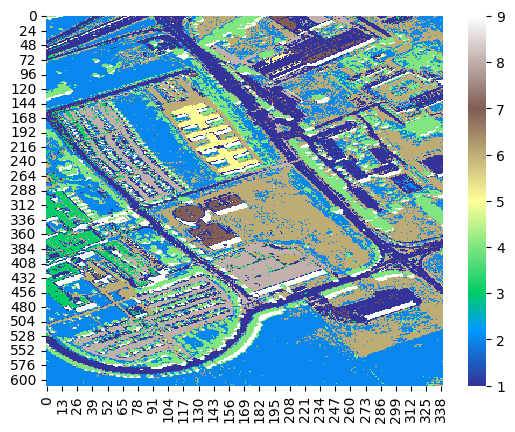

In [ ]:
df = pd.DataFrame(ymap)
fig = sns.heatmap(data=df, cmap=mpl.colormaps["terrain"])
heatmap = fig.get_figure()
heatmap.savefig("./classification_map.tif", dpi = 400)